In [2]:
import zipfile
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import re
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dropout, Dense, GlobalMaxPool1D, Embedding, Activation
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/ag-news-fastai/readme.txt
/kaggle/input/ag-news-fastai/classes.txt
/kaggle/input/ag-news-fastai/train.csv
/kaggle/input/ag-news-fastai/test.csv
/kaggle/input/ag-news-text-classifier/__results__.html
/kaggle/input/ag-news-text-classifier/train_df_cleaned.pkl
/kaggle/input/ag-news-text-classifier/ag_news_embedd_model_weights.h5
/kaggle/input/ag-news-text-classifier/__notebook__.ipynb
/kaggle/input/ag-news-text-classifier/__output__.json
/kaggle/input/ag-news-text-classifier/ag_news_embedd_model.h5
/kaggle/input/ag-news-text-classifier/test_df_cleaned.pkl
/kaggle/input/ag-news-text-classifier/custom.css
/kaggle/input/ag-news-text-classifier/__results___files/__results___8_1.png


In [3]:
train_df = pd.read_csv('../input/ag-news-fastai/train.csv', names=['ClassIndex','Title','Description'])
test_df = pd.read_csv('../input/ag-news-fastai/test.csv', names=['ClassIndex','Title','Description'])

print(train_df.shape, test_df.shape)

(120000, 3) (7600, 3)


In [4]:
train_df.head(4)

,ClassIndex,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...


In [5]:
test_df.head(3)

,ClassIndex,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...


In [6]:
ntrain_df = train_df.copy()
ntest_df = test_df.copy()

ntrain_df['set'] = 'train'
ntest_df['set']  = 'test'

df = ntrain_df.append(ntest_df, ignore_index=True)
print(df.shape)
df.head()

(127600, 4)


,ClassIndex,Title,Description,set
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",train
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,train
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,train
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,train
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",train


In [7]:
df.isna().sum()

ClassIndex     0
Title          0
Description    0
set            0
dtype: int64

#### *Class labels* {1:'World News', 2:'Sports News', 3:'Business News', 4:'Science-Technology News'}

In [9]:
df.drop_duplicates().shape
# -> no duplicates found

(127600, 4)

<AxesSubplot:xlabel='ClassIndex', ylabel='count'>

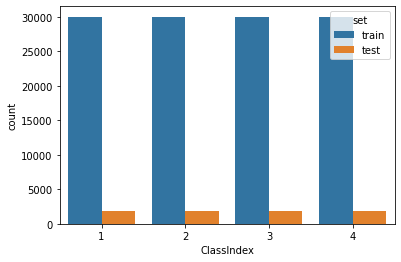

In [8]:
import seaborn as sns
sns.countplot(x ='ClassIndex', hue = "set", data = df)

#### All the class labels has equal distribution of news

#### *Analyzing data -> Text Mining on train and test data separately*

In [ ]:
train_df['full_text'] = train_df['Title'] + ' ' + train_df['Description']
test_df['full_text']  = test_df['Title']  + ' ' + test_df['Description']

train_df = train_df.drop(columns=['Title', 'Description'])
test_df  = test_df.drop(columns=['Title', 'Description'])

train_df.shape, test_df.shape

In [ ]:
# function to clean and preprocess the text field
def text_mining(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text) #remove unicode characters
    text = re.sub(' +',' ', text) #remove multiple spaces
    tokens = word_tokenize(text)
    return (" ".join(tokens)).strip()


def remove_stopwords (text):        
    list1=[word for word in text.split() if word not in stopwords.words('english')]
    return " ".join(list1)


stemmer = SnowballStemmer('english')
def stemming(text):
    stemtext = ''
    for word in text.split():
        stem = stemmer.stem(word)
        stemtext += stem
        stemtext += ' '
    stemtext = stemtext.strip()
    return stemtext


train_df['full_text'] = train_df['full_text'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
train_df['full_text'] = train_df['full_text'].apply(lambda x: text_mining(x))
train_df['full_text'] = train_df['full_text'].apply(lambda x: remove_stopwords(x))
train_df['full_text'] = train_df['full_text'].apply(lambda x: stemming(x))

test_df['full_text'] = test_df['full_text'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
test_df['full_text'] = test_df['full_text'].apply(lambda x: text_mining(x))
test_df['full_text'] = test_df['full_text'].apply(lambda x: remove_stopwords(x))
test_df['full_text'] = test_df['full_text'].apply(lambda x: stemming(x))

In [ ]:
train_df.head(2)

In [ ]:
test_df.head(2)

##### *Storing the cleaned preprocessed data so that no need to do the entire process again*

In [ ]:
train_df.to_pickle('./train_df_cleaned.pkl') 
test_df.to_pickle('./test_df_cleaned.pkl')

In [11]:
# reading cleaned preprocessed data
train_df1 = pd.read_pickle('/kaggle/input/ag-news-text-classifier/train_df_cleaned.pkl')
test_df1  = pd.read_pickle('/kaggle/input/ag-news-text-classifier/test_df_cleaned.pkl')

In [12]:
# labeling the ClassIndex column
labels = {1:'World News', 2:'Sports News', 3:'Business News', 4:'Science-Technology News'}
train_df1['ClassIndex'].replace(labels, inplace=True)
test_df1['ClassIndex'].replace(labels, inplace=True)

In [13]:
train_df1.head()

,ClassIndex,full_text
0,Business News,wall st bear claw back black reuter reuter sho...
1,Business News,carlyl look toward commerci aerospac reuter re...
2,Business News,oil economi cloud stock outlook reuter reuter ...
3,Business News,iraq halt oil export main southern pipelin reu...
4,Business News,oil price soar alltim record pose new menac us...


In [14]:
# splitting the text field by space delimiter as we will be creating w2v model and tokens
t_d = []
for i in train_df1['full_text']:
    t_d.append(i.split())
print(t_d[:2])

[['wall', 'st', 'bear', 'claw', 'back', 'black', 'reuter', 'reuter', 'shortsel', 'wall', 'street', 'dwindlingband', 'ultracyn', 'see', 'green'], ['carlyl', 'look', 'toward', 'commerci', 'aerospac', 'reuter', 'reuter', 'privat', 'invest', 'firm', 'carlyl', 'groupwhich', 'reput', 'make', 'welltim', 'occasionallycontroversi', 'play', 'defens', 'industri', 'quiet', 'placedit', 'bet', 'anoth', 'part', 'market']]


In [15]:
# initiate word2vec model
w2v_model = Word2Vec(t_d, vector_size=100, workers=32, min_count=2, window=2)
print(w2v_model)

Word2Vec(vocab=35436, vector_size=100, alpha=0.025)


In [16]:
# tokenize the data
token = Tokenizer(35436)
token.fit_on_texts(train_df1['full_text'])
token_text = token.texts_to_sequences(train_df1['full_text'])
token_text = pad_sequences(token_text)

In [17]:
# label encoding of the targget column
la = preprocessing.LabelEncoder()
y = la.fit_transform(train_df1['ClassIndex'])
y = to_categorical(y)
print(y[:5])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [18]:
# extract Word2Vec learned embedding and put them in a numpy array
embedding_matrix_w2v = np.random.random((len(token.word_index) + 1, w2v_model.vector_size))

pas = 0
for word,i in token.word_index.items():
    
    try:
        embedding_matrix_w2v[i] = w2v_model.wv[word]
    except:
        pas+=1

# define a keras model and load the pretrained Word2Vec weights matrix
emb = Embedding(len(token.word_index) + 1, w2v_model.vector_size, 
                weights=[embedding_matrix_w2v], trainable=True)
emb

In [19]:
# spilt the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(np.array(token_text), y, test_size=0.2)
print("X_train",X_train.shape, "X_test", X_test.shape)
print("y_train",y_train.shape, "y_test", y_test.shape)

X_train (96000, 99) X_test (24000, 99)
y_train (96000, 4) y_test (24000, 4)


In [34]:
# build the model
keras_model = Sequential()
keras_model.add(emb)
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(GlobalMaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Dense(200))
keras_model.add(Activation('relu'))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(4))
keras_model.add(Activation('softmax'))
keras_model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          3381800   
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 50)          7550      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 50)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 100)         15100     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 100)        

In [35]:
# train the model
keras_model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
375/375 [==============================] - 44s 116ms/step - loss: 0.3545 - acc: 0.8784 - val_loss: 0.2684 - val_acc: 0.9155
Epoch 2/10
375/375 [==============================] - 44s 116ms/step - loss: 0.2298 - acc: 0.9256 - val_loss: 0.2691 - val_acc: 0.9146
Epoch 3/10
375/375 [==============================] - 43s 115ms/step - loss: 0.1958 - acc: 0.9363 - val_loss: 0.2506 - val_acc: 0.9197
Epoch 4/10
375/375 [==============================] - 43s 115ms/step - loss: 0.1678 - acc: 0.9436 - val_loss: 0.2653 - val_acc: 0.9172
Epoch 5/10
375/375 [==============================] - 44s 117ms/step - loss: 0.1506 - acc: 0.9479 - val_loss: 0.2829 - val_acc: 0.9152
Epoch 6/10
375/375 [==============================] - 43s 116ms/step - loss: 0.1348 - acc: 0.9533 - val_loss: 0.2926 - val_acc: 0.9128
Epoch 7/10
375/375 [==============================] - 43s 116ms/step - loss: 0.1249 - acc: 0.9559 - val_loss: 0.3154 - val_acc: 0.9105
Epoch 8/10
375/375 [==============================] - 4

In [36]:
labels = la.classes_
print(labels)

['Business News' 'Science-Technology News' 'Sports News' 'World News']


In [37]:
# check prediction
predicted = keras_model.predict(X_test)

In [38]:
### Save Model and Weights

from keras.models import load_model

keras_model.save('ag_news_embedd_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# serialize weights to HDF5
keras_model.save_weights("ag_news_embedd_model_weights.h5")

# returns a compiled model
# identical to the previous one
# model = load_model('../input/ag-news-text-classifier/ag_news_embedd_model.h5')

# To predict for different data 
# predicted = model.predict(X_test)
# predicted

In [39]:
true_class = tf.argmax(y_test, 1 )
predicted_class = tf.argmax(predicted, 1 )
true_class, predicted_class

(<tf.Tensor: shape=(24000,), dtype=int64, numpy=array([0, 1, 3, ..., 0, 2, 1])>,
 <tf.Tensor: shape=(24000,), dtype=int64, numpy=array([0, 1, 3, ..., 0, 2, 1])>)

In [40]:
for i in range(10,50,3):
    print(train_df1['full_text'].iloc[i][:50], "...")
    print("Actual category: ", labels[np.argmax(y_test[i])])
    print("predicted category: ", labels[np.argmax(predicted[i])])

oil economi cloud stock outlook new york reuter so ...
Actual category:  World News
predicted category:  World News
googl ipo auction rocki start washingtonnew york r ...
Actual category:  Sports News
predicted category:  Sports News
kid rule backtoschool purchas power kid big part b ...
Actual category:  Sports News
predicted category:  Sports News
shell could target total oil giant shell could bra ...
Actual category:  Sports News
predicted category:  Sports News
expans slow japan econom growth japan slow countri ...
Actual category:  World News
predicted category:  World News
south korea lower interest rate south korea centra ...
Actual category:  Business News
predicted category:  Business News
mauritian textil firm cut job one oldest textil op ...
Actual category:  Sports News
predicted category:  Sports News
veteran inventor market float trevor bayli veteran ...
Actual category:  Business News
predicted category:  Business News
indian fill rail skill shortag network rail fli sp .

In [41]:
tf.math.confusion_matrix(labels=true_class, predictions=predicted_class, num_classes=4)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[5298,  468,   42,  149],
       [ 515, 5309,   42,  129],
       [  57,   34, 5865,   93],
       [ 320,  210,  134, 5335]], dtype=int32)>

* True Positive values:
    - ClassI: 5298; ClassII: 5309; ClassIII: 5865; ClassIV: 5355;

#### Creating another tensor model with different embedding parameters

In [31]:
# initiate word2vec model
w2v_model = Word2Vec(t_d, vector_size=50, workers=32, min_count=1, window=2)
print(w2v_model)

# tokenize the data
token = Tokenizer(67635)
token.fit_on_texts(train_df1['full_text'])
token_text = token.texts_to_sequences(train_df1['full_text'])
token_text = pad_sequences(token_text)

la = preprocessing.LabelEncoder()
y = la.fit_transform(train_df1['ClassIndex'])
y = to_categorical(y)
print(y[:5])

# extract Word2Vec learned embedding and put them in a numpy array
embedding_matrix_w2v = np.random.random((len(token.word_index) + 1, w2v_model.vector_size))

pas = 0
for word,i in token.word_index.items():
    
    try:
        embedding_matrix_w2v[i] = w2v_model.wv[word]
    except:
        pas+=1

# define a keras model and load the pretrained Word2Vec weights matrix
emb = Embedding(len(token.word_index) + 1, w2v_model.vector_size, 
                weights=[embedding_matrix_w2v], trainable=True)


# spilt the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(np.array(token_text), y, test_size=0.2)
print("X_train",X_train.shape, "X_test", X_test.shape)
print("y_train",y_train.shape, "y_test", y_test.shape)


# build the model
keras_model = Sequential()
keras_model.add(emb)
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(GlobalMaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Dense(200))
keras_model.add(Activation('relu'))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(4))
keras_model.add(Activation('softmax'))
keras_model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')
print(keras_model.summary())

# train the model
keras_model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test))

labels = la.classes_
print(labels)

# check prediction
predicted = keras_model.predict(X_test)

for i in range(10,50,3):
    print(train_df1['full_text'].iloc[i][:50], "...")
    print("Actual category: ", labels[np.argmax(y_test[i])])
    print("predicted category: ", labels[np.argmax(predicted[i])])

Word2Vec(vocab=67635, vector_size=50, alpha=0.025)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
X_train (96000, 99) X_test (24000, 99)
y_train (96000, 4) y_test (24000, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          3381800   
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 50)          7550      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 50)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
___________________________________________________

In [32]:
true_class = tf.argmax(y_test, 1 )
predicted_class = tf.argmax(predicted, 1 )
true_class, predicted_class

(<tf.Tensor: shape=(24000,), dtype=int64, numpy=array([0, 1, 3, ..., 0, 2, 1])>,
 <tf.Tensor: shape=(24000,), dtype=int64, numpy=array([0, 1, 3, ..., 0, 2, 1])>)

In [33]:
# from tensorflow.contrib.metrics import streaming_accuracy
tf.math.confusion_matrix(labels=true_class, predictions=predicted_class, num_classes=4)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[5156,  628,   53,  120],
       [ 236, 5615,   38,  106],
       [  24,   35, 5961,   29],
       [ 283,  213,  159, 5344]], dtype=int32)>

### Conclusion
* We found that with different embedding parameters, we were able to get the better accuracy of the model with the validation accuracy=92%.
* Also, the validation loss is better i.e. 0.24 
* Overall, as it is a mutilabel classification problem, accuracy is not the standard as it may give us false positive or false negative results. So, we looked at the confusion matrix to determine our model performance. We found out that our model has performed pretty good in identifying TRUE positive and TRUE negative classes as it can be seen diagonally on the above confusion matrix with following correct values:
    - ClassI: 5156; ClassII: 5615; ClassIII: 5961; ClassIV: 5344; 
    - ClassI TrueNegative: 5615+38+106+35+5961+29+213+159+5344=17500
* There are few false positive and false negative results as well for ex:
    - ClassI: FalseNegative: 628+53+120=801 ; FalsePositive: 236+24+283=543
    

### Future Work:
- We can use other transfer learning approach such as ULMFiT to further improve the model performance and reduce the false false negative or false positive error rate.
- I did tried ULMFiT model, but due to the insufficient resources available on my Google Colab, not able to finished running it.